# Load Data

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Time Series/Final_TS/data/coffee.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [ ]:
data

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD
...,...,...,...,...,...,...,...
5741,2022-08-29,240.55,240.55,240.55,240.50,1,USD
5742,2022-08-30,238.75,241.75,238.75,239.15,14,USD
5743,2022-08-31,240.75,240.75,239.65,239.10,12,USD
5744,2022-09-01,238.55,238.55,236.60,236.35,6,USD


In [ ]:
data.iloc[5072]

Date        2020-01-02 00:00:00
Open                     129.55
High                     130.95
Low                       126.5
Close                     127.1
Volume                    21506
Currency                    USD
Name: 5072, dtype: object

In [ ]:
series = data[['Close']].values
series

array([[116.5 ],
       [116.25],
       [118.6 ],
       ...,
       [239.1 ],
       [236.35],
       [228.42]])

In [ ]:
datetime.datetime(2022,1,3)

datetime.datetime(2022, 1, 3, 0, 0)

# TS Plot

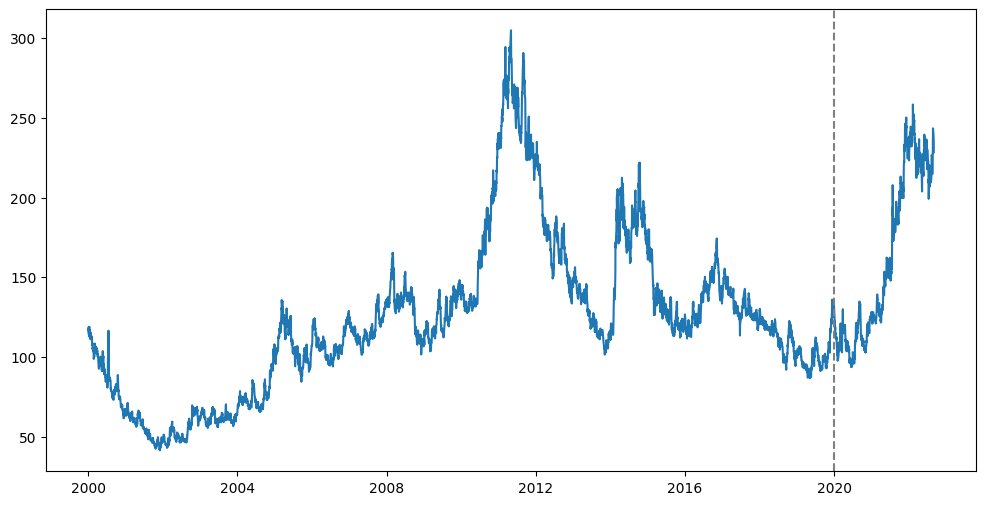

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(data['Date'], data['Close'])
plt.axvline(x = datetime.datetime(2020,1,2), color = 'grey', linestyle = '--')
plt.show()

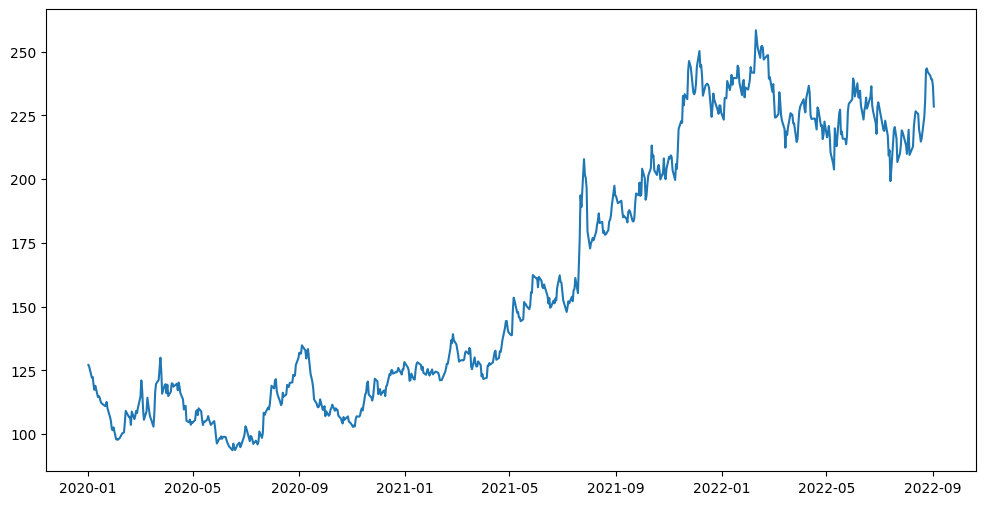

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(data['Date'][5072:], data['Close'][5072:])
plt.show()

# Normalize and Split train / test

In [ ]:
# normalize
def normalize_series(series):
    original_max = max(series)
    original_min = min(series)
    normalized_series = (series - min(series)) / (max(series) - min(series))
    return normalized_series , original_max , original_min

# de-normalize
def denormalized_series(series , original_min , original_max):
    return (series * (original_max - original_min)) + original_min

In [ ]:
norm_series , original_max , original_min = normalize_series(series)

In [ ]:
train_series = norm_series[:5072]
test_series = norm_series[5072:]
print(train_series.shape)
print(test_series.shape)

(5072, 1)
(674, 1)


# Data Windowing

In [ ]:
def windowed_dataset(series , window_size , batch_size , buffer_size = False, step = 1):
    series = tf.data.Dataset.from_tensor_slices(series)
    series = series.window(window_size + step , shift = 1 , drop_remainder = True)
    series = series.flat_map(lambda x: x.batch(window_size+step))
    series = series.map(lambda x: (x[:-step] , x[-1]))
    if buffer_size != False:
      series = series.shuffle(buffer_size)
    series = series.batch(batch_size).prefetch(1)
    return series

In [ ]:
window_size = 10  
batch_size = 32 
train_dataseries = windowed_dataset(train_series , window_size , batch_size , buffer_size = 1000)
# train_dataseries = windowed_dataset(train_series , window_size , batch_size, step = 3)

In [ ]:
train_dataseries

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
for x,y in train_dataseries.take(1):
    print(x.shape)
    print(y.shape)

(32, 5, 1)
(32, 1)


In [ ]:
x[0]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.05277145],
       [0.04897494],
       [0.04859529],
       [0.05030372],
       [0.03454822]])>

In [ ]:
y[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.04498861])>

In [ ]:
train_series[:10]

array([[0.28473804],
       [0.28378891],
       [0.29271071],
       [0.28606682],
       [0.27581625],
       [0.28872437],
       [0.2896735 ],
       [0.29403948],
       [0.29252088],
       [0.26974184]])

# LSTM Modeling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64 , return_sequences = True , input_shape = [window_size , 1]), #1-> because its a univarient
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(10 , activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 50,581
Trainable params: 50,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_selected = 1e-3

In [ ]:
initial_weigts = model.get_weights()
model_2 = model
model_2.set_weights(initial_weigts)

In [ ]:
model_2.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.Adam(learning_rate=lr_selected) , metrics = ['mae'])
history = model_2.fit(train_dataseries , epochs = 300)

Epoch 1/300


KeyboardInterrupt: ignored

# Prediction and Plot

In [ ]:
dataseries = windowed_dataset(norm_series , window_size , batch_size)

In [ ]:
for x, y in dataseries.take(1):
  print(x.shape)
  print(y.shape)

(32, 10, 1)
(32, 1)


In [ ]:
x[1]

In [ ]:
y

In [ ]:
res = model_2.predict(dataseries)

180/180 [==============================] - 4s 10ms/step


In [ ]:
list(norm_series)

In [ ]:
res.reshape(-1)

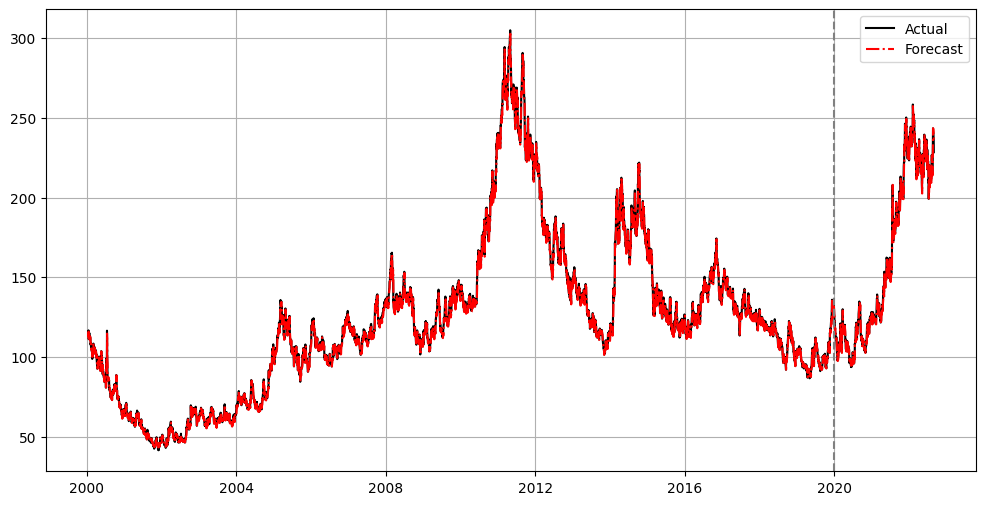

In [ ]:
res_df = pd.DataFrame({
    'Date' : data['Date'][10:], 
    'Real_norm' : norm_series[10:].reshape(-1), 
    'Pred_norm' : res.reshape(-1), 
    'Real_val' : denormalized_series(norm_series[10:].reshape(-1), original_min , original_max), 
    'Pred_val' : denormalized_series(res.reshape(-1), original_min , original_max)
})
plt.figure(figsize = (12 , 6))
plt.plot(res_df['Date'], res_df['Real_val'], 'black' , label = 'Actual')
plt.plot(res_df['Date'], res_df['Pred_val'] , 'red' , label = 'Forecast', linestyle = '-.')
plt.axvline(x = datetime.datetime(2020,1,2), color = 'grey', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

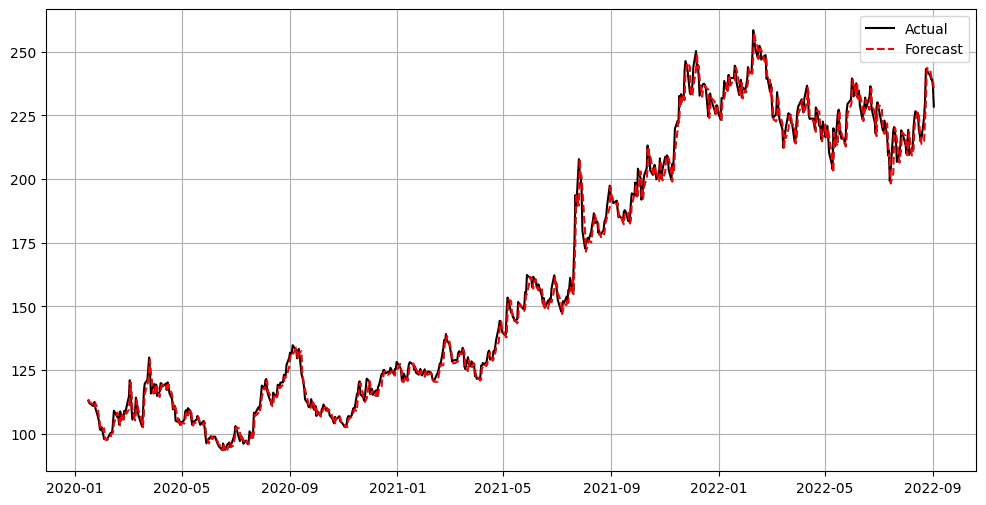

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(res_df['Date'][5072:], res_df['Real_val'][5072:], 'black' , label = 'Actual')
plt.plot(res_df['Date'][5072:], res_df['Pred_val'][5072:] , 'red' , label = 'Forecast', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

# 三步預測

In [ ]:
window_size = 10  
batch_size = 32 
train_dataseries = windowed_dataset(train_series , window_size , batch_size , buffer_size = 1000, step = 3)

In [ ]:
lr_selected = 1e-3
model_3step = model
initial_weigts = model.get_weights()
model_3step.set_weights(initial_weigts)
model_3step.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.Adam(learning_rate=lr_selected) , metrics = ['mae'])
history = model_3step.fit(train_dataseries , epochs = 300)

Epoch 1/300
159/159 [==============================] - 12s 41ms/step - loss: 6.2253e-04 - mae: 0.0255
Epoch 2/300
159/159 [==============================] - 3s 18ms/step - loss: 3.5429e-04 - mae: 0.0193
Epoch 3/300
159/159 [==============================] - 3s 19ms/step - loss: 3.2019e-04 - mae: 0.0185
Epoch 4/300
159/159 [==============================] - 5s 29ms/step - loss: 3.2671e-04 - mae: 0.0184
Epoch 5/300
159/159 [==============================] - 3s 18ms/step - loss: 2.7261e-04 - mae: 0.0170
Epoch 6/300
159/159 [==============================] - 3s 19ms/step - loss: 2.8510e-04 - mae: 0.0175
Epoch 7/300
159/159 [==============================] - 4s 25ms/step - loss: 2.4648e-04 - mae: 0.0162
Epoch 8/300
159/159 [==============================] - 5s 29ms/step - loss: 2.2280e-04 - mae: 0.0154
Epoch 9/300
159/159 [==============================] - 3s 18ms/step - loss: 2.2883e-04 - mae: 0.0159
Epoch 10/300
159/159 [==============================] - 5s 31ms/step - loss: 2.1465e-04 - 

In [ ]:
dataseries_3step = windowed_dataset(norm_series , window_size , batch_size, step = 3)

In [ ]:
res_3step = model_3step.predict(dataseries_3step)

180/180 [==============================] - 2s 7ms/step


In [ ]:
len(res_3step)

5734

In [ ]:
len(norm_series)

5746

In [ ]:
daily_pred_3step = pd.DataFrame(
    {
        'Date' : data['Date'][-len(res_3step):],
        'Real' : denormalized_series(norm_series[-len(res_3step):].reshape(-1), original_min , original_max), 
        'LSTM' : denormalized_series(res_3step.reshape(-1), original_min , original_max)
    }
)
daily_pred_3step.index = range(len(daily_pred_3step))
daily_pred_3step

,Date,Real,LSTM
0,2000-01-20,112.00,112.704548
1,2000-01-21,111.20,115.520978
2,2000-01-24,111.90,116.740143
3,2000-01-25,112.85,112.239251
4,2000-01-26,115.15,111.260239
...,...,...,...
5729,2022-08-29,240.50,244.664868
5730,2022-08-30,239.15,245.660396
5731,2022-08-31,239.10,244.301761
5732,2022-09-01,236.35,242.320501


In [ ]:
test_idx = daily_pred_3step[daily_pred_3step['Date'] == '2020-01-02'].index.values[0]

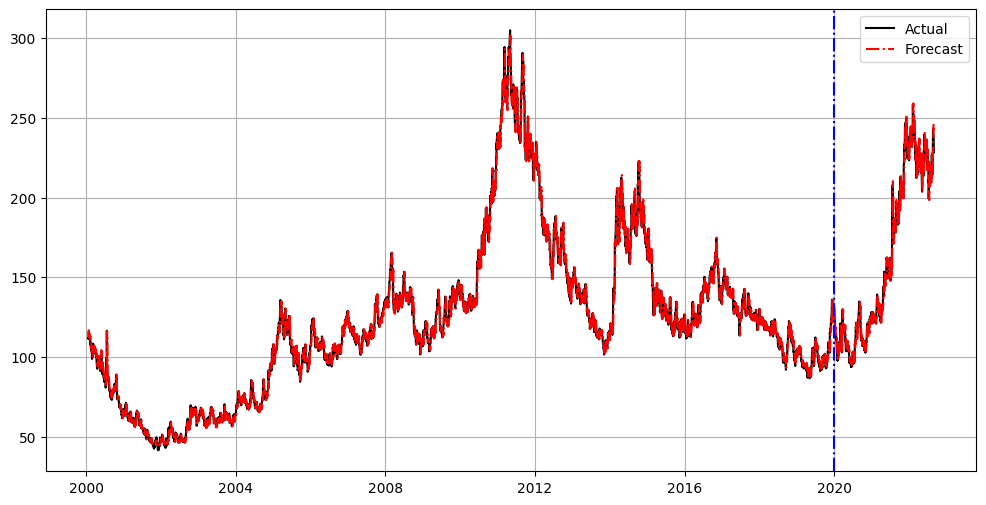

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(daily_pred_3step['Date'], daily_pred_3step['Real'], 'black' , label = 'Actual')
plt.plot(daily_pred_3step['Date'], daily_pred_3step['LSTM'] , 'red' , label = 'Forecast', linestyle = '-.')
plt.axvline(x = datetime.datetime(2020,1,2), color = 'blue', linestyle = '-.')
plt.grid()
plt.legend()
plt.show()

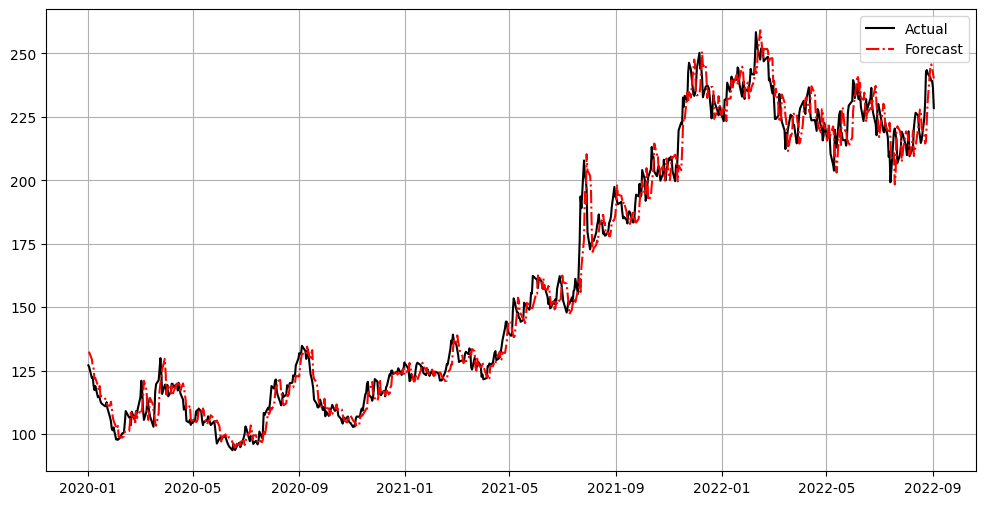

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(daily_pred_3step['Date'][test_idx:], daily_pred_3step['Real'][test_idx:], 'black' , label = 'Actual')
plt.plot(daily_pred_3step['Date'][test_idx:], daily_pred_3step['LSTM'][test_idx:] , 'red' , label = 'Forecast', linestyle = '-.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(daily_pred_3step['Real'][test_idx:], daily_pred_3step['LSTM'][test_idx:])
mae = mean_absolute_error(daily_pred_3step['Real'][test_idx:], daily_pred_3step['LSTM'][test_idx:])
print('Test MSE :', mse)
print('Test MAE :', mae)

Test MSE : 47.34383192722938
Test MAE : 5.122264622154504


In [ ]:
base_mse = mean_squared_error(daily_pred_3step['Real'][test_idx:], daily_pred_3step['Real'][test_idx-3:-3])
base_mae = mean_absolute_error(daily_pred_3step['Real'][test_idx:], daily_pred_3step['Real'][test_idx-3:-3])
print('Baseline MSE :', base_mse)
print('Baseline MAE :', base_mae)

Baseline MSE : 46.33148991097923
Baseline MAE : 5.050326409495549


In [ ]:
daily_pred_3step.to_csv('/content/drive/MyDrive/Time Series/Final_TS/prediction/daily_3step_pred.csv', index = False)

In [ ]:
daily_pred_3step['Real'][test_idx-3:-3]

5057    132.50
5058    132.15
5059    129.70
5060    127.10
5061    126.35
         ...  
5726    242.95
5727    243.40
5728    242.00
5729    240.50
5730    239.15
Name: Real, Length: 674, dtype: float64

In [ ]:
daily_pred_3step['Real'][test_idx:]

5060    127.10
5061    126.35
5062    122.15
5063    122.40
5064    119.15
         ...  
5729    240.50
5730    239.15
5731    239.10
5732    236.35
5733    228.42
Name: Real, Length: 674, dtype: float64

# Monthly Data

In [ ]:
data.index = data['Date']
data_monthly = data.resample('M').mean()
data_monthly['Month'] = pd.to_datetime(data_monthly.index)
data_monthly.index = range(len(data_monthly))
data_monthly

<ipython-input-118-37b48196a01e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_monthly = data.resample('M').mean()


,Open,High,Low,Close,Volume,Month
0,116.035000,118.382500,113.765000,115.185000,6004.650000,2000-01-31
1,106.912500,108.197500,105.657500,106.477500,4686.750000,2000-02-29
2,104.708696,105.608696,103.700000,104.636957,1700.130435,2000-03-31
3,96.534211,97.810526,95.421053,96.539474,5079.000000,2000-04-30
4,96.813636,98.438636,95.827273,96.934091,2853.181818,2000-05-31
...,...,...,...,...,...,...
268,217.992857,221.114286,214.090476,218.082381,16666.238095,2022-05-31
269,230.066667,234.145238,226.811905,230.292857,19171.095238,2022-06-30
270,216.073000,217.967500,212.446500,215.447500,8784.000000,2022-07-31
271,223.239130,227.173913,220.367391,224.221739,12029.565217,2022-08-31


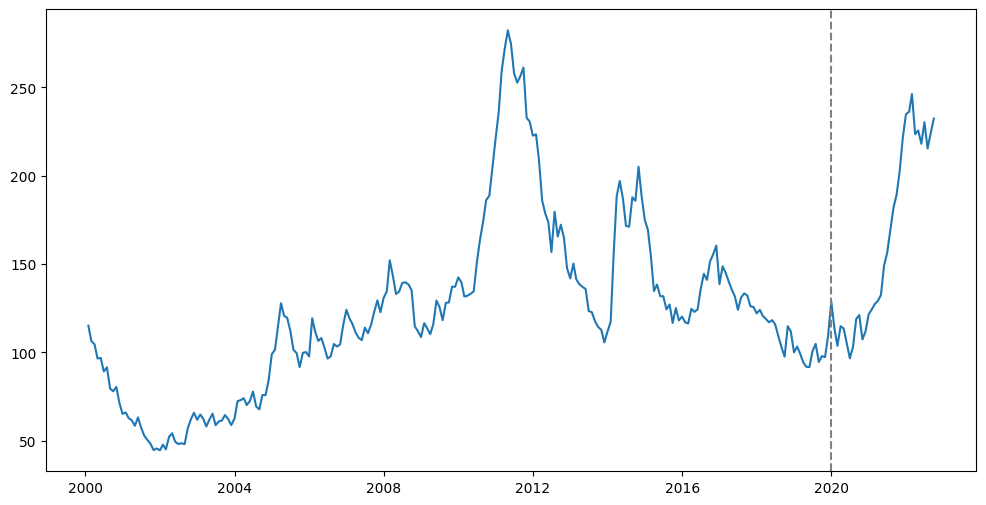

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(data_monthly['Month'], data_monthly['Close'])
plt.axvline(x = datetime.datetime(2020,1,1), color = 'grey', linestyle = '--')
plt.savefig('1.jpg')
plt.show()

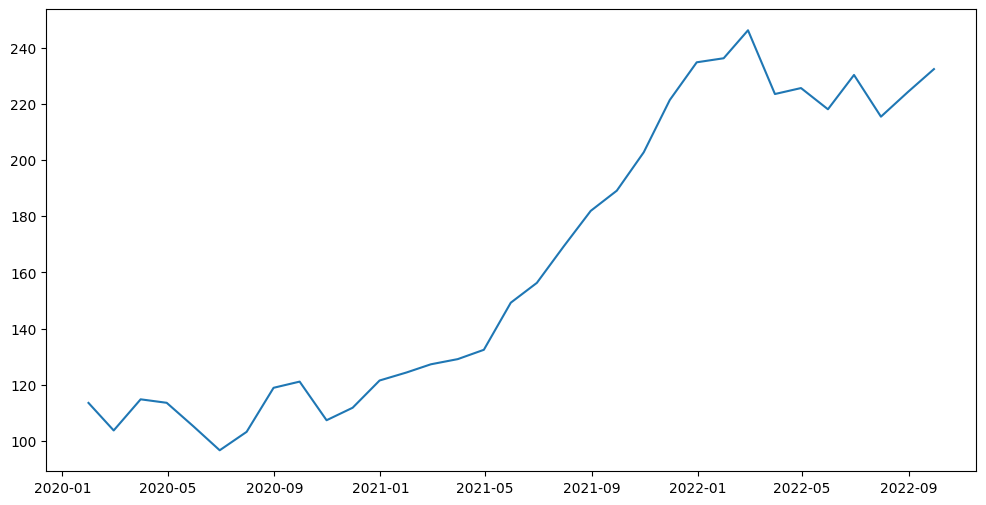

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(data_monthly['Month'][240:], data_monthly['Close'][240:])
plt.show()

In [ ]:
data_monthly[data_monthly['Month'] == '2020-01-31']

,Open,High,Low,Close,Volume,Month
240,114.921429,115.828571,112.621429,113.569048,22863.380952,2020-01-31


In [ ]:
series = data_monthly[['Close']].values
series

array([[115.185     ],
       [106.4775    ],
       [104.63695652],
       [ 96.53947368],
       [ 96.93409091],
       [ 89.21818182],
       [ 91.59473684],
       [ 79.51086957],
       [ 78.015     ],
       [ 80.47954545],
       [ 71.3525    ],
       [ 65.26      ],
       [ 66.01190476],
       [ 62.85789474],
       [ 61.63636364],
       [ 58.51      ],
       [ 63.20909091],
       [ 57.46190476],
       [ 52.91428571],
       [ 50.47173913],
       [ 48.34      ],
       [ 44.74565217],
       [ 45.6575    ],
       [ 44.63529412],
       [ 47.80714286],
       [ 45.14473684],
       [ 52.2525    ],
       [ 54.24090909],
       [ 49.42727273],
       [ 48.1675    ],
       [ 48.63333333],
       [ 48.11136364],
       [ 57.0575    ],
       [ 62.18695652],
       [ 65.88157895],
       [ 61.885     ],
       [ 64.87142857],
       [ 62.54444444],
       [ 58.06428571],
       [ 62.00238095],
       [ 65.33809524],
       [ 58.84047619],
       [ 60.93181818],
       [ 61

In [ ]:
norm_series , original_max , original_min = normalize_series(series)

In [ ]:
train_series = norm_series[:240]

## 一步(月)預測

In [ ]:
window_size = 3  
batch_size = 32 
train_dataseries = windowed_dataset(train_series , window_size , batch_size , buffer_size = 1000)
# train_dataseries = windowed_dataset(train_series , window_size , batch_size, step = 3)

In [ ]:
lr_selected = 1e-3
initial_weigts = model.get_weights()
model_month = model
model_month.set_weights(initial_weigts)

In [ ]:
model_month.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.Adam(learning_rate=lr_selected) , metrics = ['mae'])
history = model_month.fit(train_dataseries , epochs = 300)

Epoch 1/300
8/8 [==============================] - 5s 11ms/step - loss: 7.7291e-04 - mae: 0.0290
Epoch 2/300
8/8 [==============================] - 0s 9ms/step - loss: 7.1713e-04 - mae: 0.0293
Epoch 3/300
8/8 [==============================] - 0s 10ms/step - loss: 7.4099e-04 - mae: 0.0279
Epoch 4/300
8/8 [==============================] - 0s 7ms/step - loss: 6.7448e-04 - mae: 0.0274
Epoch 5/300
8/8 [==============================] - 0s 7ms/step - loss: 6.6382e-04 - mae: 0.0274
Epoch 6/300
8/8 [==============================] - 0s 9ms/step - loss: 6.7326e-04 - mae: 0.0275
Epoch 7/300
8/8 [==============================] - 0s 7ms/step - loss: 6.6156e-04 - mae: 0.0271
Epoch 8/300
8/8 [==============================] - 0s 7ms/step - loss: 6.5411e-04 - mae: 0.0272
Epoch 9/300
8/8 [==============================] - 0s 9ms/step - loss: 6.5284e-04 - mae: 0.0273
Epoch 10/300
8/8 [==============================] - 0s 10ms/step - loss: 6.5530e-04 - mae: 0.0272
Epoch 11/300
8/8 [==================

In [ ]:
dataseries = windowed_dataset(norm_series , window_size , batch_size)
res_month = model_month.predict(dataseries)

9/9 [==============================] - 1s 10ms/step


In [ ]:
len(res_month)

270

In [ ]:
len(norm_series)

273

In [ ]:
monthly_pred_1step = pd.DataFrame(
    {
        'Date' : data_monthly['Month'][-len(res_month):],
        'Real' : denormalized_series(norm_series[-len(res_month):].reshape(-1), original_min , original_max), 
        'LSTM' : denormalized_series(res_month.reshape(-1), original_min , original_max)
    }
)
monthly_pred_1step.index = range(len(monthly_pred_1step))
monthly_pred_1step

,Date,Real,LSTM
0,2000-04-30,96.539474,105.047498
1,2000-05-31,96.934091,97.650301
2,2000-06-30,89.218182,98.059859
3,2000-07-31,91.594737,89.689912
4,2000-08-31,79.510870,92.207033
...,...,...,...
265,2022-05-31,218.082381,219.868656
266,2022-06-30,230.292857,214.154856
267,2022-07-31,215.447500,229.038587
268,2022-08-31,224.221739,211.303467


In [ ]:
test_idx = monthly_pred_1step[monthly_pred_1step['Date']=="2020-01-31"].index.values[0]

In [ ]:
test_idx

237

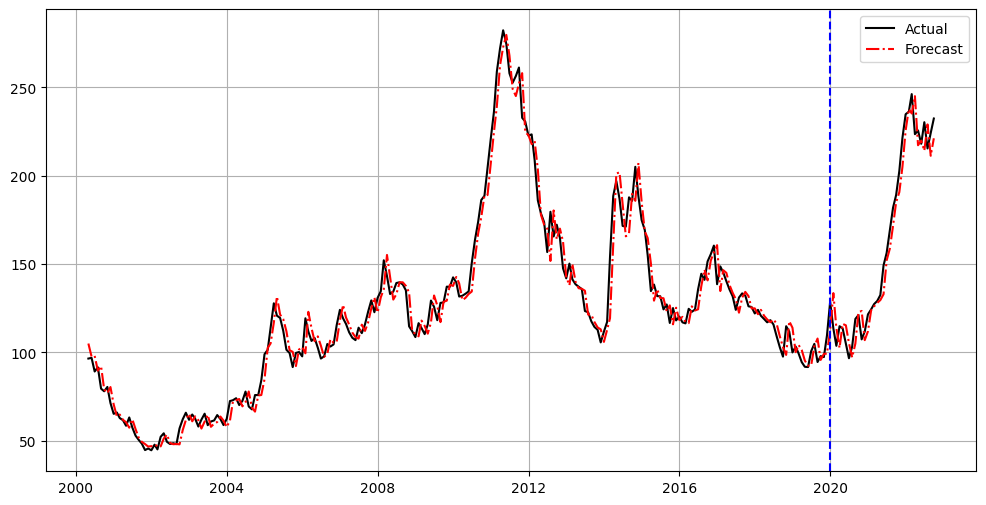

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(monthly_pred_1step['Date'], monthly_pred_1step['Real'], 'black' , label = 'Actual')
plt.plot(monthly_pred_1step['Date'], monthly_pred_1step['LSTM'] , 'red' , label = 'Forecast', linestyle = '-.')
plt.axvline(x = datetime.datetime(2020,1,2), color = 'blue', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

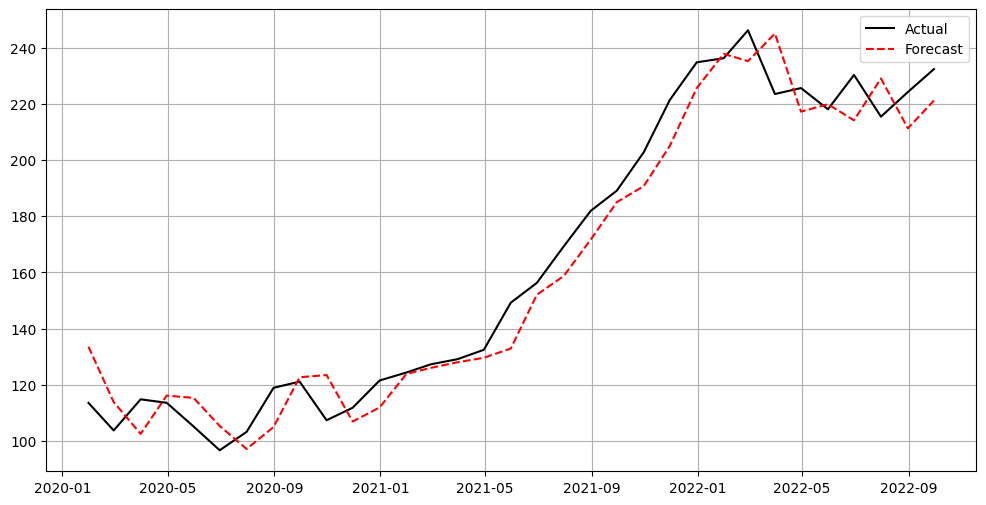

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(monthly_pred_1step['Date'][test_idx:], monthly_pred_1step['Real'][test_idx:], 'black' , label = 'Actual')
plt.plot(monthly_pred_1step['Date'][test_idx:], monthly_pred_1step['LSTM'][test_idx:] , 'red' , label = 'Forecast', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

In [ ]:
monthly_pred_1step.to_csv('/content/drive/MyDrive/Time Series/Final_TS/prediction/monthly_1step_pred.csv', index = False)

In [ ]:
mse = mean_squared_error(monthly_pred_1step['Real'][test_idx:], monthly_pred_1step['LSTM'][test_idx:])
mae = mean_absolute_error(monthly_pred_1step['Real'][test_idx:], monthly_pred_1step['LSTM'][test_idx:])
print('Test MSE :', mse)
print('Test MAE :', mae)

Test MSE : 117.25321902493998
Test MAE : 9.174506910594125


In [ ]:
base_mse = mean_squared_error(monthly_pred_1step['Real'][test_idx:], monthly_pred_1step['Real'][test_idx-1:-1])
base_mae = mean_absolute_error(monthly_pred_1step['Real'][test_idx:], monthly_pred_1step['Real'][test_idx-1:-1])
print('Baseline MSE :', base_mse)
print('Baseline MAE :', base_mae)

Baseline MSE : 116.30098764089944
Baseline MAE : 9.321293568392177


## 三步(月)預測

In [ ]:
window_size = 3  
batch_size = 32 
train_dataseries = windowed_dataset(train_series , window_size , batch_size , buffer_size = 1000, step = 3)

In [ ]:
lr_selected = 1e-3
model_month_3step = model
model_month_3step.set_weights(initial_weigts)
model_month_3step.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.Adam(learning_rate=lr_selected) , metrics = ['mae'])
history = model_month_3step.fit(train_dataseries , epochs = 300)

Epoch 1/300
8/8 [==============================] - 5s 13ms/step - loss: 0.0029 - mae: 0.0545
Epoch 2/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0535
Epoch 3/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mae: 0.0529
Epoch 4/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0522
Epoch 5/300
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mae: 0.0528
Epoch 6/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0530
Epoch 7/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0516
Epoch 8/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0519
Epoch 9/300
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mae: 0.0534
Epoch 10/300
8/8 [==============================] - 0s 8ms/step - loss: 0.0026 - mae: 0.0520
Epoch 11/300
8/8 [==============================] - 0s 11ms/step - loss: 0.

In [ ]:
dataseries_3step = windowed_dataset(norm_series , window_size , batch_size, step = 3)

In [ ]:
res_month_3step = model_month_3step.predict(dataseries_3step)

9/9 [==============================] - 1s 9ms/step


In [ ]:
monthly_pred_3step = pd.DataFrame(
    {
        'Date' : data_monthly['Month'][-len(res_month_3step):],
        'Real' : denormalized_series(norm_series[-len(res_month_3step):].reshape(-1), original_min , original_max), 
        'LSTM' : denormalized_series(res_month_3step.reshape(-1), original_min , original_max)
    }
)
monthly_pred_3step.index = range(len(monthly_pred_3step))
monthly_pred_3step

,Date,Real,LSTM
0,2000-06-30,89.218182,108.046754
1,2000-07-31,91.594737,98.370228
2,2000-08-31,79.510870,101.482239
3,2000-09-30,78.015000,90.394688
4,2000-10-31,80.479545,96.140813
...,...,...,...
263,2022-05-31,218.082381,237.410128
264,2022-06-30,230.292857,205.090397
265,2022-07-31,215.447500,206.777932
266,2022-08-31,224.221739,204.938981


In [ ]:
test_idx = monthly_pred_3step[monthly_pred_3step['Date'] == '2020-01-31'].index.values[0]

In [ ]:
test_idx

235

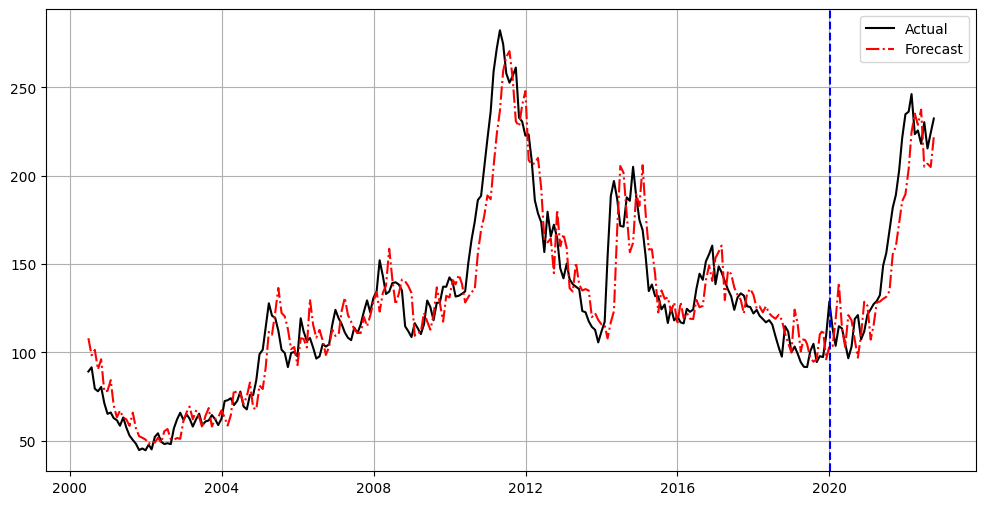

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(monthly_pred_3step['Date'], monthly_pred_3step['Real'], 'black' , label = 'Actual')
plt.plot(monthly_pred_3step['Date'], monthly_pred_3step['LSTM'] , 'red' , label = 'Forecast', linestyle = '-.')
plt.axvline(x = datetime.datetime(2020,1,2), color = 'blue', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

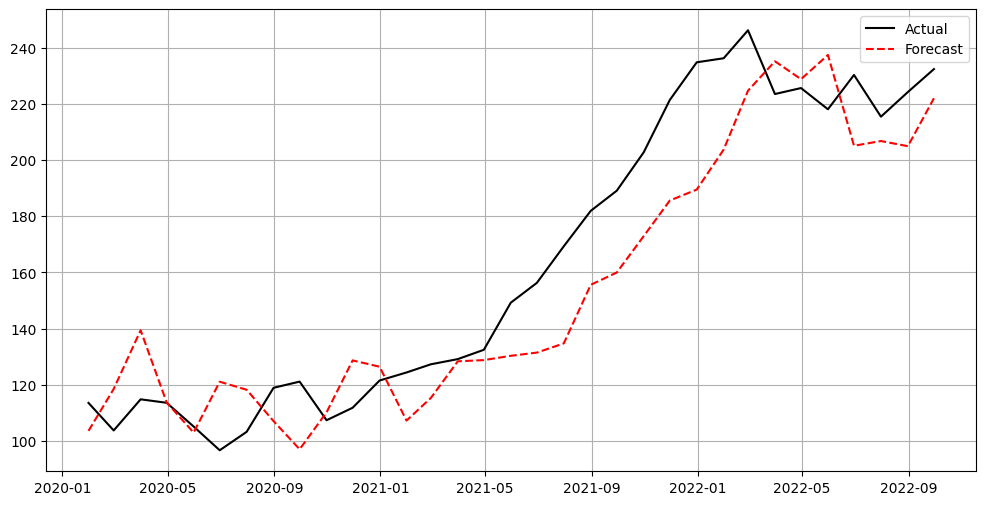

In [ ]:
plt.figure(figsize = (12 , 6))
plt.plot(monthly_pred_3step['Date'][test_idx:], monthly_pred_3step['Real'][test_idx:], 'black' , label = 'Actual')
plt.plot(monthly_pred_3step['Date'][test_idx:], monthly_pred_3step['LSTM'][test_idx:] , 'red' , label = 'Forecast', linestyle = '--')
plt.grid()
plt.legend()
plt.show()

In [ ]:
monthly_pred_3step.to_csv('/content/drive/MyDrive/Time Series/Final_TS/prediction/monthly_3step_pred.csv', index = False)

In [ ]:
mse = mean_squared_error(monthly_pred_3step['Real'][test_idx:], monthly_pred_3step['LSTM'][test_idx:])
mae = mean_absolute_error(monthly_pred_3step['Real'][test_idx:], monthly_pred_3step['LSTM'][test_idx:])
print('Test MSE :', mse)
print('Test MAE :', mae)

Test MSE : 436.1331453288683
Test MAE : 17.616831063321474


In [ ]:
base_mse = mean_squared_error(monthly_pred_3step['Real'][test_idx:], monthly_pred_3step['Real'][test_idx-3:-3])
base_mae = mean_absolute_error(monthly_pred_3step['Real'][test_idx:], monthly_pred_3step['Real'][test_idx-3:-3])
print('Baseline MSE :', base_mse)
print('Baseline MAE :', base_mae)

Baseline MSE : 450.8170472000688
Baseline MAE : 17.192964675282656
